In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn.functional as F
import numpy as np
import soundfile as sf
from torch.utils.data import DataLoader
from models.model_scalar import MixingModelScalar
from models.model_scalar_v2 import MixingModelScalar2d
from data.dataset import MultitrackAudioDataset
from data.dataset_utils import split_songlist
from data.medleydb_split import weathervane_music, musdb18_mixed

from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

Torch version:  1.6.0
Device:  cuda


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
weights_dir = './weights'
chunk_length = 1

In [5]:
train_songlist, val_songlist, test_songlist = split_songlist(weathervane_music,
                                                            train_val_test_split=(0.8, 0.2, 0.0),
                                                            summary=True)

Dataset split:
Train: 20 tracks
['CelestialShore_DieForUs', 'HeladoNegro_MitadDelMundo', 'Lushlife_ToynbeeSuite', 'FamilyBand_Again', 'SweetLights_YouLetMeDown', 'AvaLuna_Waterduct', 'TheSoSoGlos_Emergency', 'PurlingHiss_Lolita', 'TheDistricts_Vermont', 'BigTroubles_Phantom', 'AClassicEducation_NightOwl', 'Auctioneer_OurFutureFaces', 'InvisibleFamiliars_DisturbingWildlife', 'SecretMountains_HighHorse', 'Grants_PunchDrunk', 'Snowmine_Curfews', 'NightPanther_Fire', 'HezekiahJones_BorrowedHeart', 'DreamersOfTheGhetto_HeavyLove', 'HopAlong_SisterCities']
--------------------------------------------------------------------------------
Val: 5 tracks
['StevenClark_Bounty', 'StrandOfOaks_Spacestation', 'PortStWillow_StayEven', 'FacesOnFilm_WaitingForGa', 'Creepoid_OldTree']
--------------------------------------------------------------------------------
Test: 0 tracks
[]


In [4]:
train_songlist = ['CelestialShore_DieForUs', 'HeladoNegro_MitadDelMundo', 'Lushlife_ToynbeeSuite', 'FamilyBand_Again', 'SweetLights_YouLetMeDown', 'AvaLuna_Waterduct', 'TheSoSoGlos_Emergency', 'PurlingHiss_Lolita', 'TheDistricts_Vermont', 'BigTroubles_Phantom', 'AClassicEducation_NightOwl', 'Auctioneer_OurFutureFaces', 'InvisibleFamiliars_DisturbingWildlife', 'SecretMountains_HighHorse', 'Grants_PunchDrunk', 'Snowmine_Curfews', 'NightPanther_Fire', 'HezekiahJones_BorrowedHeart', 'DreamersOfTheGhetto_HeavyLove', 'HopAlong_SisterCities']
val_songlist = ['StevenClark_Bounty', 'StrandOfOaks_Spacestation', 'PortStWillow_StayEven', 'FacesOnFilm_WaitingForGa', 'Creepoid_OldTree']

In [5]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=train_songlist + musdb18_mixed,
    chunk_length=chunk_length,
    normalize=False,
    compute_features=False,
    augment_data=True
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=val_songlist,
    chunk_length=chunk_length,
    normalize=False,
    compute_features=False,
    augment_data=True
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))

Train: 30 tracks, 7445 chunks
Val: 5 tracks, 1408 chunks


In [6]:
train_loader = DataLoader(d_train,
                          batch_size=64,
                          shuffle=False,
                          num_workers=8,
                          pin_memory=True,
                          drop_last=False,
                          timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val,
                        batch_size=64,
                        shuffle=False,
                        num_workers=8,
                        pin_memory=True,
                        drop_last=False,
                        timeout=0,
                        worker_init_fn=None)

-145.4684162717831 -110.16972272924151 129.51297372760655
-1.0 -0.7573446219652796 0.8903167921044352


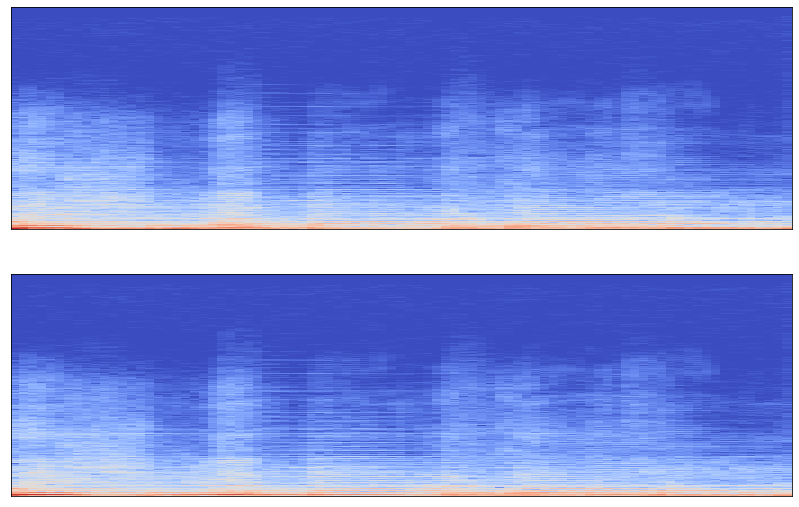

In [9]:
train_features, gt_features = d_train[50]

features = np.sum(train_features, axis=0)

fig = plt.figure(figsize=(14, 9))

ax1 = plt.subplot(2,1,1)
print(np.min(features), np.mean(features), np.max(features))
librosa.display.specshow(features)

ax2 = plt.subplot(2,1,2, sharex=ax1)
norm_features = librosa.util.normalize(features)
print(np.min(norm_features), np.mean(norm_features), np.max(norm_features))
librosa.display.specshow(norm_features)
plt.show()

In [10]:
model = MixingModelScalar2d().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

908400 trainable parameters


In [7]:
weights = './saved_models/scalar2d_scalar2d_2550.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [11]:
criterion = torch.nn.MSELoss(reduction='mean')
# criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.CosineSimilarity()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

In [12]:
metrics = {
    'mse': Loss(criterion)
}

# trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

def train_step(trainer, batch):
    model.train()
    optimizer.zero_grad()

    train_features, gt_features = batch
    masked, _ = model(train_features.float().to(device))

#     masked = F.normalize(masked)
#     gt_features = F.normalize(gt_features)

    loss = criterion(masked, gt_features.float().to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


def inference_step(engine, batch):
    model.eval()

    with torch.no_grad():
        train_features, gt_features = batch
        masked, _ = model(train_features.float().to(device))

#         masked = F.normalize(masked)
#         gt_features = F.normalize(gt_features)
        
        return masked, gt_features.float().to(device)

    
trainer = Engine(train_step)

# train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
train_evaluator = Engine(inference_step)
for name, metric in metrics.items():
    metric.attach(train_evaluator, name)


# val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = Engine(inference_step)
for name, metric in metrics.items():
    metric.attach(val_evaluator, name)

In [13]:
def score_function(engine):
    val_loss = engine.state.metrics['mse']
    return -val_loss

handler = EarlyStopping(
    patience=7,
    score_function=score_function,
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [14]:
training_history = {
    'loss': []
}
validation_history = {
    'loss': []
}
last_epoch = []


@trainer.on(Events.ITERATION_COMPLETED(every=30))
def log_training_loss():
    print("{}/{} : {} - loss: {:.5f}"
          .format(trainer.state.epoch, trainer.state.max_epochs, trainer.state.iteration, trainer.state.output))

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['mse']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}, Avg loss: {:.5f}"
          .format(trainer.state.epoch, loss))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['mse']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}, Avg loss: {:.5f}"
          .format(trainer.state.epoch, loss))

In [15]:
checkpointer = ModelCheckpoint(
    './saved_models',
    'scalar2d',
    # keep all the objects
    n_saved=None,
    create_dir=True,
    save_as_state_dict=True,
    require_empty=False
)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'scalar2d': model})

In [14]:
trainer.run(train_loader, max_epochs=20)

1/20 : 30 - loss: 676.27197
1/20 : 60 - loss: 356.02158
Training Results - Epoch: 1, Avg loss: 623.74628
Validation Results - Epoch: 1, Avg loss: 629.11544
2/20 : 90 - loss: 390.22937
2/20 : 120 - loss: 200.51108
2/20 : 150 - loss: 171.36916
Training Results - Epoch: 2, Avg loss: 493.42447
Validation Results - Epoch: 2, Avg loss: 455.22100
3/20 : 180 - loss: 457.22940
3/20 : 210 - loss: 167.54576
3/20 : 240 - loss: 271.62311
Training Results - Epoch: 3, Avg loss: 403.31309
Validation Results - Epoch: 3, Avg loss: 377.65806
4/20 : 270 - loss: 158.23131
4/20 : 300 - loss: 117.48710
Training Results - Epoch: 4, Avg loss: 379.16902
Validation Results - Epoch: 4, Avg loss: 381.31695
5/20 : 330 - loss: 134.44429
5/20 : 360 - loss: 76.22986
5/20 : 390 - loss: 105.85635
Training Results - Epoch: 5, Avg loss: 355.15912
Validation Results - Epoch: 5, Avg loss: 355.56510
6/20 : 420 - loss: 273.60187
6/20 : 450 - loss: 117.58382
6/20 : 480 - loss: 189.67551
Training Results - Epoch: 6, Avg loss: 3

State:
	iteration: 1640
	epoch: 20
	epoch_length: 82
	max_epochs: 20
	output: 921.6956176757812
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [16]:
trainer.run(train_loader, max_epochs=40)

21/40 : 1650 - loss: 247.54884
21/40 : 1680 - loss: 93.84145
21/40 : 1710 - loss: 86.90099
Training Results - Epoch: 21, Avg loss: 239.09416
Validation Results - Epoch: 21, Avg loss: 255.74648
22/40 : 1740 - loss: 118.41324
22/40 : 1770 - loss: 85.75533
22/40 : 1800 - loss: 77.29308
Training Results - Epoch: 22, Avg loss: 237.32288
Validation Results - Epoch: 22, Avg loss: 255.34800
23/40 : 1830 - loss: 59.20496
23/40 : 1860 - loss: 83.60155
Training Results - Epoch: 23, Avg loss: 232.14510
Validation Results - Epoch: 23, Avg loss: 252.53925
24/40 : 1890 - loss: 69.80461
24/40 : 1920 - loss: 145.58063
24/40 : 1950 - loss: 183.10846
Training Results - Epoch: 24, Avg loss: 223.33297
Validation Results - Epoch: 24, Avg loss: 240.86424
25/40 : 1980 - loss: 183.88991
25/40 : 2010 - loss: 175.22493
25/40 : 2040 - loss: 88.21286
Training Results - Epoch: 25, Avg loss: 217.69181
Validation Results - Epoch: 25, Avg loss: 235.21457
26/40 : 2070 - loss: 84.53278
26/40 : 2100 - loss: 116.76344
26/

State:
	iteration: 3280
	epoch: 40
	epoch_length: 82
	max_epochs: 40
	output: 784.1422729492188
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [18]:
trainer.run(train_loader, max_epochs=60)

41/60 : 3300 - loss: 74.19770
41/60 : 3330 - loss: 106.39394
41/60 : 3360 - loss: 84.11391
Training Results - Epoch: 41, Avg loss: 158.65009
Validation Results - Epoch: 41, Avg loss: 172.36265
42/60 : 3390 - loss: 59.89767
42/60 : 3420 - loss: 92.59345
Training Results - Epoch: 42, Avg loss: 156.28657
Validation Results - Epoch: 42, Avg loss: 170.27181
43/60 : 3450 - loss: 107.53073
43/60 : 3480 - loss: 102.37669
43/60 : 3510 - loss: 108.44269
Training Results - Epoch: 43, Avg loss: 155.01917
Validation Results - Epoch: 43, Avg loss: 167.99601
44/60 : 3540 - loss: 167.67212
44/60 : 3570 - loss: 110.93838
44/60 : 3600 - loss: 103.63485
Training Results - Epoch: 44, Avg loss: 152.71366
Validation Results - Epoch: 44, Avg loss: 166.35269
45/60 : 3630 - loss: 60.24105
45/60 : 3660 - loss: 77.38006
45/60 : 3690 - loss: 730.93835
Training Results - Epoch: 45, Avg loss: 149.36327
Validation Results - Epoch: 45, Avg loss: 163.79569
46/60 : 3720 - loss: 56.87853
46/60 : 3750 - loss: 82.25066
Tr

State:
	iteration: 4920
	epoch: 60
	epoch_length: 82
	max_epochs: 60
	output: 647.3058471679688
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [21]:
trainer.run(train_loader, max_epochs=70)

61/70 : 4950 - loss: 63.90605
61/70 : 4980 - loss: 62.10334
Training Results - Epoch: 61, Avg loss: 122.28193
Validation Results - Epoch: 61, Avg loss: 140.97893
62/70 : 5010 - loss: 108.85799
62/70 : 5040 - loss: 71.23698
62/70 : 5070 - loss: 96.58202
Training Results - Epoch: 62, Avg loss: 121.15605
Validation Results - Epoch: 62, Avg loss: 139.82647
63/70 : 5100 - loss: 165.85590
63/70 : 5130 - loss: 67.13016
63/70 : 5160 - loss: 105.84484
Training Results - Epoch: 63, Avg loss: 120.17543
Validation Results - Epoch: 63, Avg loss: 139.50935
64/70 : 5190 - loss: 58.50455
64/70 : 5220 - loss: 47.17536
Training Results - Epoch: 64, Avg loss: 119.25564
Validation Results - Epoch: 64, Avg loss: 138.62885
65/70 : 5250 - loss: 73.49546
65/70 : 5280 - loss: 44.26962
65/70 : 5310 - loss: 63.24987
Training Results - Epoch: 65, Avg loss: 117.68598
Validation Results - Epoch: 65, Avg loss: 137.65428
66/70 : 5340 - loss: 192.53882
66/70 : 5370 - loss: 101.26698
66/70 : 5400 - loss: 88.38141
Train

State:
	iteration: 5740
	epoch: 70
	epoch_length: 82
	max_epochs: 70
	output: 616.2142944335938
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

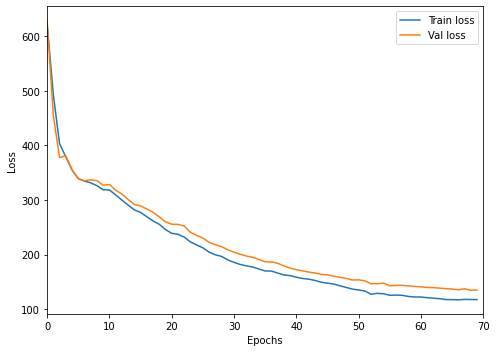

In [22]:
plt.figure(figsize=(7, 5))
plt.plot(training_history['loss'], label='Train loss')
plt.plot(validation_history['loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 70)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

---
> Previous setup + 10 tracks from MUSDB18 in train set

In [16]:
trainer.run(train_loader, max_epochs=30)

1/30 : 30 - loss: 7300.07324
1/30 : 60 - loss: 391.47845
1/30 : 90 - loss: 179.67984
Training Results - Epoch: 1, Avg loss: 340.37640
Validation Results - Epoch: 1, Avg loss: 541.98681
2/30 : 120 - loss: 332.73428
2/30 : 150 - loss: 257.52686
2/30 : 180 - loss: 2.12795
2/30 : 210 - loss: 213.43143
Training Results - Epoch: 2, Avg loss: 301.01519
Validation Results - Epoch: 2, Avg loss: 483.88322
3/30 : 240 - loss: 129.05930
3/30 : 270 - loss: 133.43755
3/30 : 300 - loss: 129.95796
3/30 : 330 - loss: 155.58733
Training Results - Epoch: 3, Avg loss: 327.67857
Validation Results - Epoch: 3, Avg loss: 510.86669
4/30 : 360 - loss: 106.39390
4/30 : 390 - loss: 125.55019
4/30 : 420 - loss: 206.08746
4/30 : 450 - loss: 209.58705
Training Results - Epoch: 4, Avg loss: 325.50086
Validation Results - Epoch: 4, Avg loss: 503.59083
5/30 : 480 - loss: 138.59793
5/30 : 510 - loss: 142.25253
5/30 : 540 - loss: 111.65249
5/30 : 570 - loss: 1.08521
Training Results - Epoch: 5, Avg loss: 315.30586
Valida

State:
	iteration: 3510
	epoch: 30
	epoch_length: 117
	max_epochs: 30
	output: 327.0655822753906
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [18]:
trainer.run(train_loader, max_epochs=60)

31/60 : 3540 - loss: 61.88780
31/60 : 3570 - loss: 113.68330
31/60 : 3600 - loss: 65.44010
Training Results - Epoch: 31, Avg loss: 114.75155
Validation Results - Epoch: 31, Avg loss: 186.02364
32/60 : 3630 - loss: 81.39663
32/60 : 3660 - loss: 57.18116
32/60 : 3690 - loss: 1.16774
32/60 : 3720 - loss: 189.77637
Training Results - Epoch: 32, Avg loss: 112.01240
Validation Results - Epoch: 32, Avg loss: 181.67961
33/60 : 3750 - loss: 82.92961
33/60 : 3780 - loss: 90.27672
33/60 : 3810 - loss: 89.23785
33/60 : 3840 - loss: 102.59016
Training Results - Epoch: 33, Avg loss: 110.02634
Validation Results - Epoch: 33, Avg loss: 178.51461
34/60 : 3870 - loss: 47.23158
34/60 : 3900 - loss: 61.95229
34/60 : 3930 - loss: 190.56610
34/60 : 3960 - loss: 114.77383
Training Results - Epoch: 34, Avg loss: 107.51370
Validation Results - Epoch: 34, Avg loss: 174.50402
35/60 : 3990 - loss: 88.26351
35/60 : 4020 - loss: 89.95513
35/60 : 4050 - loss: 65.50034
35/60 : 4080 - loss: 1.43419
Training Results - 

State:
	iteration: 7020
	epoch: 60
	epoch_length: 117
	max_epochs: 60
	output: 159.95736694335938
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

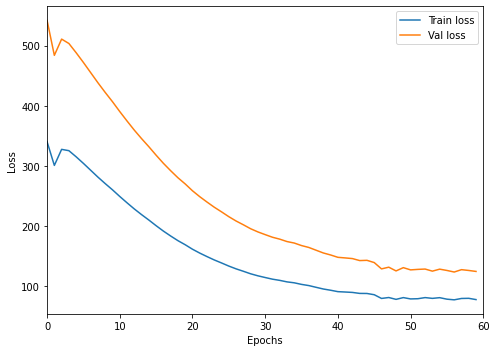

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(training_history['loss'], label='Train loss')
plt.plot(validation_history['loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 60)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))